## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de Hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
# Métricas
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# Split y validación
from sklearn.model_selection import train_test_split, GridSearchCV

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [4]:
df = pd.read_csv("./data/bank-full.csv", sep=";")

display(df.head())
print()
print(df.info())
print()
display(df.describe())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None



,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


El dataset contiene 45211 filas, 17 columnas y no presenta valores nulos, no será necesario una fase de imputación.


Tipos de variables:

- Numéricas hay 7 
- Categóricas hay 10

La variable objetivo del problema es y, ya que indica si el cliente ha contratado o no el producto bancario ofrecido. El resto de variables describen características del cliente y de la campaña, por lo que se utilizan como variables predictoras.

In [6]:
frec_abs = df["y"].value_counts()

frec_abs

y
no     39922
yes     5289
Name: count, dtype: int64

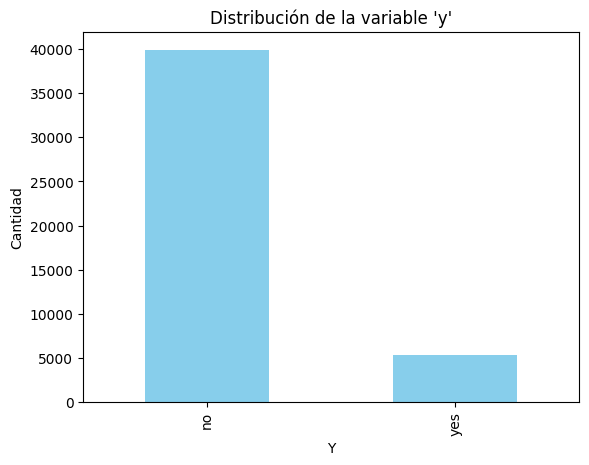

In [7]:
frec_abs.plot(
    kind = 'bar',
    color = 'skyblue'
)

plt.title("Distribución de la variable 'y'")
plt.xlabel('Y')
plt.ylabel('Cantidad')
plt.show()

El target muestra un fuerte desbalanceo, con una mayoría de clientes que no contratan el producto, lo cual es habitual en problemas de marketing.

Pasemos a preparar los datos

In [15]:
#Separamos X e y
X = df.drop('y', axis = 1)
y = df['y']

#Obtenemos los train y set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=0.2, 
    random_state = 42,
    stratify=y
)

In [16]:
#Separamos categóricas y numéricas
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64']).columns.tolist()

print("Categóricas: ", categorical_features)
print("Numéricas: ", numerical_features)

Categóricas:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numéricas:  ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [17]:
#Aplicamos one-hot encoding en train y test
X_train_encoded = pd.get_dummies(
    X_train,
    columns= categorical_features,
    drop_first=False,
    dtype = int
)

X_test_encoded = pd.get_dummies(
    X_test,
    columns= categorical_features,
    drop_first=False,
    dtype = int
)

print(X_train_encoded.info())
display(X_train_encoded.head())

<class 'pandas.core.frame.DataFrame'>
Index: 36168 entries, 24001 to 44229
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  36168 non-null  int64
 1   balance              36168 non-null  int64
 2   day                  36168 non-null  int64
 3   duration             36168 non-null  int64
 4   campaign             36168 non-null  int64
 5   pdays                36168 non-null  int64
 6   previous             36168 non-null  int64
 7   job_admin.           36168 non-null  int64
 8   job_blue-collar      36168 non-null  int64
 9   job_entrepreneur     36168 non-null  int64
 10  job_housemaid        36168 non-null  int64
 11  job_management       36168 non-null  int64
 12  job_retired          36168 non-null  int64
 13  job_self-employed    36168 non-null  int64
 14  job_services         36168 non-null  int64
 15  job_student          36168 non-null  int64
 16  job_technician       36

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
24001,36,861,29,140,2,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
43409,24,4126,5,907,4,185,7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
20669,44,244,12,1735,4,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
18810,48,0,31,35,11,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
23130,38,257,26,57,10,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [18]:

y_train_encoded = pd.get_dummies(
    y_train,
    drop_first=False,
    dtype = int
)

y_test_encoded = pd.get_dummies(
    y_test,
    drop_first=False,
    dtype = int
)

display(y_train_encoded.head())

,no,yes
24001,1,0
43409,0,1
20669,0,1
18810,1,0
23130,1,0


Creamos el modelo de Regresión Logística para tener un punto de referencia:

In [21]:
#Como se ha mapeado las variable target con get_dummies, se obtienen dos columnas.
#Los clasificadores de scikit-learn no aceptan el target en ese formato.
#Nos quedamos con solamente una columna del target, en este caso la del 'yes', porque es la que nos interesa:

y_train_final = y_train_encoded['yes']
y_test_final = y_test_encoded['yes']

log_reg = LogisticRegression(max_iter = 1000, random_state= 42)

log_reg.fit(X_train_encoded, y_train_final)

h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [22]:
y_pred_log = log_reg.predict(X_test_encoded)

In [28]:
print("=== Regresión Logística ===")
print("Classification report: ")
print(classification_report(y_test_final, y_pred_log))
print("Accuracy: ")
print(accuracy_score(y_test_final, y_pred_log))

=== Regresión Logística ===
Classification report: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.63      0.35      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043

Accuracy: 
0.9005860886873825


Una vez hecha la Regresión Logística, pasamos a hacer el árbol de decisión (sin optimizar)

In [24]:
tree_clf = DecisionTreeClassifier(random_state=42)

In [25]:
tree_clf.fit(X_train_encoded, y_train_final)

DecisionTreeClassifier(random_state=42)

In [26]:
y_pred_tree = tree_clf.predict(X_test_encoded)

In [29]:
print("=== Árbol de Decisión ===")
print("Classification report: ")
print(classification_report(y_test_final, y_pred_tree))
print("Accuracy: ")
print(accuracy_score(y_test_final, y_pred_tree))

=== Árbol de Decisión ===
Classification report: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7985
           1       0.46      0.48      0.47      1058

    accuracy                           0.87      9043
   macro avg       0.70      0.70      0.70      9043
weighted avg       0.88      0.87      0.88      9043

Accuracy: 
0.8745991374543846


Aunque la regresión logística obtiene un mayor accuracy global, este resultado está influido por el fuerte desbalance del dataset. Al analizar las métricas por clase, se observa que el árbol de decisión presenta un mayor recall para la clase positiva, lo que indica una mejor capacidad para identificar clientes que realmente contratarán el producto, a costa de un mayor número de falsos positivos.

El árbol que se ha entrenado no tiene restricciones, tiende a sobreajustar y no está adaptado al desbalance. Con la optimización buscamos controlar la complejidad del árbol, mejorar la generalización y encontrar un mejor compromiso entre: recall de la clase 1 y accuracy global.

In [30]:
param_grid = {
    'max_depth': [None, 5, 10, 15, 20], #Exploramos hasta una profuncidad moderada
    'min_samples_split': [2, 10, 50, 100], #se evitan nodos con muy pocas muestras
    'min_samples_leaf': [1, 5, 10, 50], #se mejora la generalización
    'class_weight': [None, 'balanced'] #se trata el desbalance
}


In [32]:
#Utilizamos el método de búsqueda de GridSearch por ser el más exhaustivo

scoring = "f1"
# Motivo:
# dataset desbalanceado
# combina precision y recall
# penaliza modelos que ignoran la clase 1

grid_search = GridSearchCV(
    estimator = tree_clf,
    param_grid= param_grid,
    scoring= scoring,
    cv = 5,
    n_jobs = 1
)

grid_search.fit(X_train_encoded, y_train_final)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 5, 10, 50],
                         'min_samples_split': [2, 10, 50, 100]},
             scoring='f1')

In [33]:
grid_search.best_params_


{'class_weight': 'balanced',
 'max_depth': 15,
 'min_samples_leaf': 5,
 'min_samples_split': 100}

In [36]:
best_model = grid_search.best_estimator_


In [37]:
y_pred_opt = best_model.predict(X_test_encoded)

print(classification_report(y_test_final, y_pred_opt))
print("Accuracy:", accuracy_score(y_test_final, y_pred_opt))


              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7985
           1       0.40      0.87      0.55      1058

    accuracy                           0.83      9043
   macro avg       0.69      0.85      0.72      9043
weighted avg       0.91      0.83      0.86      9043

Accuracy: 0.834347008736039


Tras la optimización de hiperparámetros, el árbol de decisión mejora su capacidad de generalización y su rendimiento sobre la clase minoritaria, superando al modelo sin ajustar y ofreciendo una alternativa competitiva frente a la regresión logística baseline.


---

**Recall de la clase 1 (el cambio más importante)**

|Modelo	Recall | Recall clase 1 |
| -- | --|
|Logística | 0.35|
|Árbol base	| 0.48|
|Árbol optimizado | 0.87|

Esto es un salto enorme.

- Antes detectaba se detectaba un ~35 % de los clientes que sí contratarían
- Ahora detectas ~87 %

Es decir, el modelo optimizado encuentra casi todos los clientes potenciales.



--- 

**Precision de la clase 1 (el precio a pagar)**

|Modelo	| Precision clase 1 |
|--|--|
|Logística | 0.63|
|Árbol base | 0.46|
|Árbol optimizado | 0.40 |

¿Qué significa? 
- Muchos clientes predichos como “sí” luego no lo serán.
- Hay más falsos positivos

Esto es el trade-off clásico:

- sube recall, por tanto,  baja precision




---

**F1-score: la métrica clave aquí**

|Modelo|F1 clase 1|
| ------ | ------| 
|Logística| 0.45|
|Árbol base|0.47|
|Árbol optimizado|0.55|

Esto es muy importante:
- El árbol optimizado es el mejor modelo para la clase 1
- Mejora claramente a los otros dos
- Si el objetivo es detectar clientes que sí contratarán, este modelo es el más adecuado.

---

Aunque el árbol de decisión optimizado presenta una menor accuracy global, mejora de forma muy significativa el recall y el f1-score de la clase positiva, lo que indica una mayor capacidad para identificar a los clientes que realmente contratan el producto. Dado el carácter desbalanceado del dataset y el contexto de negocio, este comportamiento resulta preferible frente a modelos más conservadores como la regresión logística baseline.